In [9]:
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.models import Model

from sklearn.metrics import mean_squared_error

import numpy as np
import math


import matplotlib.pyplot as plt



import pandas as pd

In [5]:
import time

In [6]:
from tensorflow.keras import Input

In [7]:
def load_data(filename, sequence_length):
  raw_data = pd.read_csv(filename)
  del raw_data['date']
  print(raw_data.head())
  raw_data = raw_data.values
  for x in range(0, raw_data.shape[0]):
    for y in range(0, raw_data.shape[1]):
      if (raw_data[x][y]==0):
        raw_data[x][y] = raw_data[x-1][y]

  data = raw_data.tolist()

  result = []
  for index in range(len(data) - sequence_length):
    result.append(data[index: index + sequence_length])

  d0 = np.array(result, dtype=float)
  dr = np.zeros_like(d0)
  dr[:,1:,:] = d0[:,1:,:] / d0[:,0:1,:] - 1


  start = 3000
  end = int(dr.shape[0] + 1)
  unnormalised_bases = d0[start:end, 0:1, 5]


  split_line = round(0.9*dr.shape[0])
  shape = int(split_line)
  training_data = dr[:shape, :]

  np.random.shuffle(training_data)

  X_train = training_data[:, :-1]
  Y_train = training_data[:, -1]
  Y_train = Y_train[:, 5]

  X_test = dr[int(split_line):-1]
  Y_test = dr[int(split_line):, 49, :]
  Y_test = Y_test[:, 5]

  Y_daybefore = dr[int(split_line):, 48, :]
  Y_daybefore = Y_daybefore[:, 5]


  sequence_length = sequence_length
  window_size = sequence_length-1

  return X_train, Y_train, X_test, Y_test, Y_daybefore, unnormalised_bases, window_size







In [42]:

window_size = 0.2
activation_function = 'linear'
input = Input(shape = (49, 15))
x = input
x = Bidirectional(LSTM(300, return_sequences=True))(x)
x = Dropout(0.2)(x)

x = Bidirectional(LSTM(300*2, return_sequences=True))(x)
x = Dropout(0.2)(x)

x = Bidirectional(LSTM(300*2))(x)
x = Dropout(0.2)(x)

output = Dense(units = 1)(x)

model = Model(input, output)




In [43]:
model.compile(optimizer='adam', loss ='mse', metrics=['acc'])


In [40]:
def fit_model(model, X_train, Y_train, batch_num, num_epoch, val_split):
  start = time.time()

  model.fit(X_train, Y_train, batch_num, epochs = num_epoch)
  training_time = int(math.floor(time.time() - start))
  return model, training_time

In [47]:
def test_model(model, X_test, Y_test, unnormalised_bases):
  y_predict = model.predict(X_test)

  real_y_test = np.zeros_like(Y_test)
  real_y_predict = np.zeros_like(y_predict)

  for i in range(Y_test.shape[0]-1):
    y = Y_test[i]
    predict = y_predict[i]
    real_y_test[i] = unnormalized_bases[i]
    real_y_predict[i] = (predict+1)*unnormalized_bases[i]

  fig = plt.figure(figsize=(10,5))
  ax = fig.add_subplot(111)
  ax.set_title("Bitcoin Price Over Time")
  plt.plot(real_y_predict, color = 'green', label = 'Predicted Price')
  plt.plot(real_y_test, color = 'red', label = 'Real Price')
  ax.set_ylabel("Price (USD)")
  ax.set_xlabel("Time (Days)")
  ax.legend()
      
  return y_predict, real_y_test, real_y_predict, fig

In [14]:
def binary_price(delta_predict, delta_real):
  delta_predict_1_0 = np.empty(delta_predict.shape)
  delta_real_1_0 = np.empty(delta_real.shape)


  for i in range(delta_predict.shape[0]):
    if delta_predict[i][0] > 0:
      delta_predict_1_0[i][0] = 1
    else:
      delta_predict_1_0[i][0] = 1

  for i in range(delta_real.shape[0]):
    if delta_real[i][0] > 0:
      delta_real_1_0[i][0] = 1
    else:
      delta_real_1_0[i][0] = 1
  return delta_predict_1_0, delta_real_1_0



In [15]:
def find_positives_negatives(delta_predict_1_0, delta_real_1_0):
  true_pos = 0
  false_pos = 0
  true_neg = 0
  false_neg = 0

  for i in range(delta_real_1_0.shape[0]):
    real = delta_real_1_0[i][0]
    predicted = delta_predict_1_0[i][0]
    if real == 1:
      if real == 1:
        true_pos +=1
      else:
        false_neg += 1
    elif real == 0:
      if predicted == 0:
        true_neg += 1
      else:
        false_pos += 1
  return true_pos, false_pos, true_neg, false_neg

In [16]:
def calculate_statistics(true_pos, true_neg, false_neg, y_predict, Y_test):
  precision = float(true_pos) / (true_pos + false_pos)
  recall = float(true_pos) / (true_pos + false_neg)
  F1 = float(2 * precision * recall) / (precision + recall)
  #Get Mean Squared Error
  MSE = mean_squared_error(y_predict.flatten(), Y_test.flatten())

  return precision, recall, F1, MSE

In [44]:
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 49, 15)]          0         
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 49, 600)           758400    
_________________________________________________________________
dropout_9 (Dropout)          (None, 49, 600)           0         
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 49, 1200)          5764800   
_________________________________________________________________
dropout_10 (Dropout)         (None, 49, 1200)          0         
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 1200)              8644800   
_________________________________________________________________
dropout_11 (Dropout)         (None, 1200)             

In [56]:
def price_change(Y_daybefore, Y_test, y_predict):
  Y_daybefore = np.reshape(Y_daybefore, (-1, 1))
  Y_test = np.reshape(Y_test, (-1, 1))

    #The difference between each predicted value and the value from the day before
  delta_predict = (y_predict - Y_daybefore[:354]) / (1+Y_daybefore[:354])

    #The difference between each true value and the value from the day before
  delta_real = (Y_test[:354] - Y_daybefore[:354]) / (1+Y_daybefore[:354])

    #Plotting the predicted percent change versus the real percent change
  fig = plt.figure(figsize=(10, 6))
  ax = fig.add_subplot(111)
  ax.set_title("Percent Change in Bitcoin Price Per Day")
  plt.plot(delta_predict, color='green', label = 'Predicted Percent Change')
  plt.plot(delta_real, color='red', label = 'Real Percent Change')
  plt.ylabel("Percent Change")
  plt.xlabel("Time (Days)")
  ax.legend()
  plt.show()
    
  return Y_daybefore, Y_test, delta_predict, delta_real, fig

In [45]:
X_train, Y_train, X_test, Y_test, Y_daybefore, unnormalized_bases, window_size = load_data("drive/My Drive/bitcoin_csv.csv", 50)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)
print(Y_daybefore.shape)
print(unnormalized_bases.shape)
print(window_size)

   txVolume(USD)  adjustedTxVolume(USD)  ...  blockSize  blockCount
0            NaN                    NaN  ...       3010          14
1            NaN                    NaN  ...      13129          61
2            NaN                    NaN  ...      20033          93
3            NaN                    NaN  ...      22031          94
4            NaN                    NaN  ...      26527         123

[5 rows x 15 columns]
(3200, 49, 15)
(3200,)
(354, 50, 15)
(355,)
(355,)
(555, 1)
49


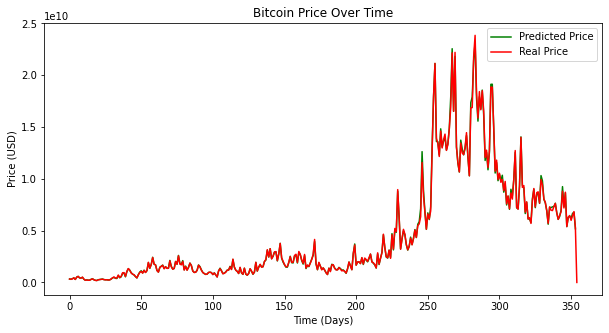

In [48]:
 y_predict, real_y_test, real_y_predict, fig1 = test_model(model, X_test, Y_test, unnormalized_bases)

#Show the plot
plt.show(fig1)

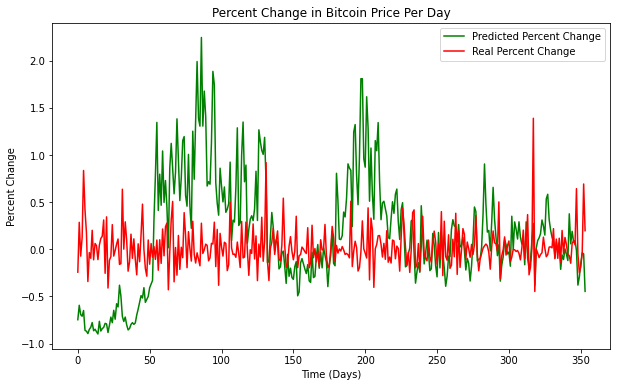

In [57]:
Y_daybefore, Y_test, delta_predict, delta_real, fig2 = price_change(Y_daybefore, Y_test, y_predict)

#Show the plot
plt.show(fig2)

In [58]:
model.save('Bitcoin_price_prediction_algorithm.h5')